In [1]:
import os
import time
import warnings
import numpy as np
import random as rnd
import pandas as pd
from collections import defaultdict

# Librería Genética
from deap import base, creator, tools, algorithms

from sklearn.utils import shuffle
# Subfunciones de estimadores
from sklearn.base import clone
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][30]
from sklearn.base import is_classifier
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/base.py][535]
from sklearn.model_selection._validation import _fit_and_score
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py][346]
from sklearn.model_selection._search import BaseSearchCV
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][386]
from sklearn.model_selection._search import check_cv
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_split.py][1866]
from sklearn.model_selection._search import _check_param_grid
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_search.py][343]
from sklearn.metrics.scorer import check_scoring
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/metrics/scorer.py][250]
from sklearn.utils.validation import _num_samples
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][105]
from sklearn.utils.validation import indexable
# [https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/utils/validation.py][208]
from multiprocessing import Pool, Manager, cpu_count

# Selección para estimadores
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metricas para estimadores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

# Estimadores
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer

#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Ensembles algorithms
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:

# find distance error al 0.2%
def distance_error(estimator, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    # coord pred
    x1 = np.int32((y_pred + 2) % 3)
    y1 = np.int32((y_pred - 1) / 3)
    # coord real
    x2 = np.int32((y_test + 2) % 3)
    y2 = np.int32((y_test - 1) / 3)
    # pasar variacion a distancias metros
    vx = np.abs(x1 - x2)*1.5
    vy = np.abs(y1 - y2)*1.5
    #vx = vx*0.5 + (vx-1)*(vx>0)
    #vy = vy*0.5 + (vy-1)*(vy>0)
    # pitagoras
    err_distance = np.sqrt(vx*vx + vy*vy)
    return err_distance

def _createDataset(frecuencias, values, seed = 7):
    # crear dataset
    names_ = frecuencias[0].columns.values
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index()
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index()
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuffle(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

def set_models():
    rs = 1
    models = []
    # LDA : Warning(Variables are collinear)
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    #"""
    models.append(('SVC', SVC(random_state=rs)))
    models.append(('GaussianNB', GaussianNB()))
    models.append(('MLPClassifier', MLPClassifier()))
    #"""
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    #"""
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=rs)))
    models.append(('LogisticRegression', LogisticRegression()))
    # Bagging and Boosting
    # models.append(('ExtraTreesClassifier', ExtraTreesClassifier(n_estimators=150)))
    models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state=rs)))
    models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier(random_state=rs),
                                                            random_state=rs)))
    # models.append(('AdaBoostClassifier', AdaBoostClassifier(DecisionTreeClassifier())))
    models.append(('RandomForestClassifier', RandomForestClassifier(random_state=rs)))
    models.append(('GradientBoostingClassifier',
                   GradientBoostingClassifier(random_state=rs)))
    # models.append(('GradientBoostingClassifier', GradientBoostingClassifier()))
    # Voting
    estimators = []
    estimators.append(("Voting_GradientBoostingClassifier", GradientBoostingClassifier(random_state=rs)))
    estimators.append(("Voting_ExtraTreesClassifier", ExtraTreesClassifier(random_state=rs)))
    voting = VotingClassifier(estimators)
    models.append(('VotingClassifier', voting))
    #"""
    return models



In [3]:
def _initIndividual(individuo, maxints):
	"""[Iniciar Individuo]
	Arguments:
		pcls {[creator.Individual]} -- [Iniciar individuo con indices aleatorios]
		maxints {[params_size]} -- [lista de máximos índices]
	Returns:
		[creator.Individual] -- [Creación de individuo]
	"""
	return individuo(rnd.randint(0, maxint) for maxint in maxints)

def _mutIndividual(individual, maxints, prob_mutacion):
	"""[Mutación Individuo]
	Arguments:
		individual {[creator.Individual]} -- [Individuo de población]
		maxints {[lista]} -- [lista de máximos índices]
		prob_mutacion {[float]} -- [probabilidad de mutación del gen]
	Returns:
		[creator.Individual] -- [Individuo mutado]
	"""
	for i in range(len(maxints)):
		if rnd.random() < prob_mutacion:
			individual[i] = rnd.randint(0, maxints[i])
	return individual,

def _cxIndividual(ind1, ind2, prob_cruce):
	"""[Cruce de Individuos]
	Arguments:
		ind1 {[creator.Individual]} -- [Individuo 1]
		ind2 {[creator.Individual]} -- [Individuo 2]
		indpb {[float]} -- [probabilidad de emparejar]
		gene_type {[list]} -- [tipos de dato de los parámetros, CATEGORICO o NUMERICO]
	Returns:
		[creator.Individual,creator.Individual] -- [nuevos Individuos]
	"""
	CATEGORICO = 1  # int o str
	NUMERICO = 2  # float
	for i in range(len(ind1)):
		if rnd.random() < prob_cruce:
			sorted_ind = sorted([ind1[i], ind2[i]])
			ind1[i] = rnd.randint(sorted_ind[0], sorted_ind[1])
			ind2[i] = rnd.randint(sorted_ind[0], sorted_ind[1])
	return ind1, ind2

def _individual_to_params(frecuencias, values):
    # crear dataset
    names_ = frecuencias[0].columns.values
    seed = 7
    # reestructuracion
    salida_final = pd.DataFrame(columns=names_)
    for sec in range(1,16):
        dataset = pd.DataFrame(columns=names_)
        corte = min([frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values])
        #l = [frecuencias[i][frecuencias[i]['Sector']==sec].shape[0] for i in values]
        #corte = max(l)
        #tx=l.index(max(l))
        tx = 0
        dataset[names_[tx]] = dataset[names_[tx]].append(frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]])
        dataset = dataset.reset_index(drop=True)
        for tx in range(1,5):
            dataset[names_[tx]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx]].reset_index(drop=True)
        dataset[names_[tx+1]] = frecuencias[int(values[tx])][frecuencias[int(values[tx])]['Sector']==sec][:corte][names_[tx+1]].reset_index(drop=True)
        # join parts
        salida_final = salida_final.append(dataset)
    # shuffle dataset
    salida_final = shuffle(salida_final, random_state=seed).reset_index(drop=True)
    salida_final = salida_final.apply(pd.to_numeric)
    # dataframe to X,y 
    X = salida_final[names_[:-1]]
    y = salida_final[names_[-1]]
    return X,y

def _evalFunction(individual, frecuencias, scorer, num_folds, score_cache, desv_cache, error_cache, resultados_cache):
	"""[Evaluación del modelo]
	Arguments:
		individual {[creator.Individual]} -- [Individuo]
		frecuencias {[list]} -- [lista de dataframes]
		X {[array]} -- [Input]
		y {[array]} -- [Output]
		scorer {[string]} -- [Parámetro de evaluación, precisión]
		cv {[int | cross-validation]} -- [Especificación de los folds]
		uniform {[boolean]} -- [True hace que la data se distribuya uniformemente en los folds]
		fit_params {[dict | None]} -- [parámetros para estimator.fit]
	Keyword Arguments:
		verbose {integer} -- [Mensajes de descripción] (default: {0})
		error_score {numerico} -- [valor asignado si ocurre un error en fitting] (default: {'raise'})
		score_cache {dict} -- [description] (default: {{}})
	"""
	X, y = _individual_to_params(frecuencias, individual)
	score = 0
	n_test = 0
	name = str(individual.est).split('(')[0]
	paramkey = str(np.array(individual)+1)
	if paramkey in score_cache:
		score = score_cache[paramkey]
	else:
		kfold = KFold(n_splits=10, shuffle=False)
		#cv_results = cross_val_score(estimator, X, y, cv=kfold, scoring=scoring)
		cv_results = cross_val_score(individual.est, X, y, cv=kfold, scoring=scorer)
		score = cv_results.mean()
		score_cache[paramkey] = score
		desv_cache[paramkey] = cv_results.std()
		dis_err = distance_error(individual.est, X, y)
		error_cache[paramkey] = np.mean(dis_err)
		results = {'Modelo': name, 'Configuracion':np.int32(individual)+1, 'values': cv_results, 'Accuracy': score, 'stdAccuracy': desv_cache[paramkey], 'errorMetrico': error_cache[paramkey], 'error':dis_err}  
		resultados_cache.append(results)
	return (score,)


In [4]:
class EvolutiveSearchCV:
	def __init__(self, estimator, scoring=None, num_folds=4,
				refit=True, verbose=False, population_size=50,
				gene_mutation_prob=0.2, gene_crossover_prob=0.5,
				tournament_size=3, generations_number=10, gene_type=None,
				n_jobs=1, uniform=True, error_score='raise',
				fit_params={}):
		# Parámetros iniciales
		self.estimator = estimator
		#self.params = params
		self.scoring = scoring
		self.num_folds = num_folds
		self.refit = refit
		self.verbose = verbose
		self.population_size = population_size
		self.gene_mutation_prob = gene_mutation_prob
		self.gene_crossover_prob = gene_crossover_prob
		self.tournament_size = tournament_size
		self.generations_number = generations_number
		self.gene_type = gene_type
		self.n_jobs = n_jobs
		self.uniform = uniform
		self.error_score = error_score
		self.fit_params = fit_params
		# Parámetros adicionales
		self._individual_evals = {}
		self.all_history_ = None
		self.all_logbooks_ = None
		self._cv_results = None
		self.best_score_ = None
		self.best_params_ = None
		self.scorer_ = None
		#self.score_cache = {}
		self.__manager = Manager()
		self.score_cache = self.__manager.dict()
		self.desv_cache = self.__manager.dict()
		self.error_cache = self.__manager.dict()
		self.resultados = self.__manager.list()
		#self.score_cache = dict()
		#self.desv_cache = dict()
		#self.error_cache = dict()
		# Fitness [base.Fitness], objetivo 1
		creator.create("FitnessMax", base.Fitness, weights=(1.0,))
		# Individuo [list], parámetros:est, FinessMax
		creator.create("Individual", list, est=clone(self.estimator), fitness=creator.FitnessMax)
	#@property
	def cv_results_(self):
		if self._cv_results is None:
			out = defaultdict(list)
			gen = self.all_history_
			# Get individuals and indexes, their list of scores,
			# and additionally the name_values for this set of parameters
			idxs, individuals, each_scores = zip(*[(idx, indiv, np.mean(indiv.fitness.values))
											for idx, indiv in list(gen.genealogy_history.items())
											if indiv.fitness.valid and not np.all(np.isnan(indiv.fitness.values))])
			#name_values, _, _ = _get_param_types_maxint(self.params)
			# Add to output
			#out['param_index'] += [p] * len(idxs)
			out['index'] += idxs
			#out['params'] += [_individual_to_params(indiv, name_values) for indiv in individuals]
			out['params'] += [str(np.add(indiv,1)) for indiv in individuals]
			out['mean_test_score'] += [np.nanmean(scores) for scores in each_scores]
			out['std_test_score'] += [np.nanstd(scores) for scores in each_scores]
			out['min_test_score'] += [np.nanmin(scores) for scores in each_scores]
			out['max_test_score'] += [np.nanmax(scores) for scores in each_scores]
			out['nan_test_score?'] += [np.any(np.isnan(scores)) for scores in each_scores]
			self._cv_results = out
		return self._cv_results
	@property
	def best_index_(self):
		return np.argmax(self.cv_results_['max_test_score'])
	# fit y refit general
	def fit(self, frecuencias):
		self.best_estimator_ = None
		self.best_mem_score_ = float("-inf")
		self.best_mem_params_ = None
		#_check_param_grid(self.params)
		self._fit(frecuencias)
		#if self.refit:
		#	self.best_estimator_ = clone(self.estimator)
		#	#self.best_estimator_.set_params(**self.best_mem_params_)
		#	self.best_estimator_.fit(frecuencias)
	# fit individual
	def _fit(self, frecuencias):
		self._cv_results = None  # Indicador de necesidad de actualización
		self.scorer_ = check_scoring(self.estimator, scoring=self.scoring)
		#n_samples = _num_samples(X)
		# verificar longitudes x,y 
		#if _num_samples(y) != n_samples:
		#	raise ValueError('Target [y], data [X] dont agree')
		#cv = check_cv(self.cv, y=y, classifier=is_classifier(self.estimator))
		toolbox = base.Toolbox()
		# name_values = lista de parametros, gene_type = [1:categorico; 2:numérico], maxints = size(parametros)
		#name_values, self.gene_type, maxints = _get_param_types_maxint(parameter_dict)
		maxints = [5]*5
		#if self.verbose:
		#	print("Tipos: %s, rangos: %s" % (self.gene_type, maxints))
		# registro de función Individuo
		toolbox.register("individual", _initIndividual, creator.Individual, maxints=maxints)
		# registro de función Población
		toolbox.register("population", tools.initRepeat, list, toolbox.individual)
		# Paralelísmo, create pool
		if not isinstance(self.n_jobs, int):
			self.n_jobs=1
		pool = Pool(self.n_jobs)
		toolbox.register("map", pool.map)
		# registro de función Evaluación
		toolbox.register("evaluate", _evalFunction,
						frecuencias=frecuencias,
						scorer=self.scorer_, num_folds=10, 
						score_cache=self.score_cache,
						desv_cache=self.desv_cache,
						error_cache=self.error_cache,
						resultados_cache=self.resultados)
		# registro de función Cruce
		toolbox.register("mate", _cxIndividual, prob_cruce=self.gene_crossover_prob)
		# registro de función Mutación
		toolbox.register("mutate", _mutIndividual, prob_mutacion=self.gene_mutation_prob, maxints=maxints)
		# registro de función Selección
		toolbox.register("select", tools.selTournament, tournsize=self.tournament_size)
		# Creación de Población
		pop = toolbox.population(n=self.population_size)
		# Mejor Individuo que ha existido
		hof = tools.HallOfFame(1)
		# Stats
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("avg", np.nanmean)
		stats.register("min", np.nanmin)
		stats.register("max", np.nanmax)
		stats.register("std", np.nanstd)
		# Genealogía
		hist = tools.History()
		# Decoración de operadores de variaznza
		toolbox.decorate("mate", hist.decorator)
		toolbox.decorate("mutate", hist.decorator)
		hist.update(pop)
		# Posibles combinaciones
		if self.verbose:
			print('--- Evolve in {0} possible combinations ---'.format(np.prod(np.array(maxints) + 1)))
		pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=self.gene_crossover_prob, 
										mutpb=self.gene_mutation_prob,
										ngen=self.generations_number, 
										stats=stats,
										halloffame=hof, 
										verbose=self.verbose)
		#pop, logbook = algorithms.eaGenerateUpdate(toolbox,
		#								ngen=self.generations_number, stats=stats,
		#								halloffame=hof, verbose=self.verbose)
		# Save History
		self.all_history_ = hist
		self.all_logbooks_ = logbook
		# Mejor score y parametros
		current_best_score_ = hof[0].fitness.values[0]
		current_best_params_ = str(hof[0]) #_individual_to_params(hof[0], name_values)
		#if self.verbose:
		#	print("Best individual is: %s\nwith fitness: %s" % (
		#		current_best_params_, current_best_score_))
		if current_best_score_ > self.best_mem_score_:
			self.best_mem_score_ = current_best_score_
			self.best_mem_params_ = current_best_params_
		# fin paralelización, close pool
		pool.close()
		pool.join()
		self.best_score_ = current_best_score_
		self.best_params_ = current_best_params_

In [5]:
test_size = 0.2
num_folds = 10
seed = 7
frecuencias = []
names_ = ['Be01', 'Be02', 'Be03', 'Be04', 'Be05', 'Sector']

frecuencias.append(pd.read_csv('sinFiltro/Tx_0x01'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x02'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x03'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x04'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x05'))#, names=names_))
frecuencias.append(pd.read_csv('sinFiltro/Tx_0x06'))#, names=names_))
"""
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx1.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx2.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx3.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx4.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx5.csv', names=names_))
frecuencias.append(pd.read_csv('Filtrado/LocalizationNew_Tx6.csv', names=names_))
"""
num_jobs=cpu_count()
estimadores = set_models()
salida = {}

In [6]:
"""
def set_models():
    rs = 1
    models = []
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    return models
"""
estimadores = set_models()

reserva = {}
lista_resultados = []
for name, model in estimadores:
    print("\nModeling...", name)
    splits = 10
    simetricas = [[i]*5 for i in range(6)]
    #for individual in simetricas:
    #acc, desv, err = evaluate(frecuencias, individual, model)
    #salida[str(name)+"-"+str(individual)] = str(acc) + "-"+ str(desv) + "-" + str(err)
    #print(name," ", individual, "\t", acc, "\t", desv, "\t", err)
    gs = EvolutiveSearchCV(estimator=model, scoring="accuracy", num_folds=10, n_jobs=num_jobs,
                        verbose=True, refit=True, 
                        population_size=100, 
                        gene_mutation_prob=0.3, 
                        gene_crossover_prob=0.5,
                        tournament_size=4,
                        generations_number=11)
    gs.fit(frecuencias)
    reserva[name]=(gs.score_cache, gs.desv_cache , gs.error_cache)
    lista_resultados = lista_resultados + list(gs.resultados)
    


Modeling... LinearDiscriminantAnalysis
--- Evolve in 7776 possible combinations ---
gen	nevals	avg     	min     	max     	std      
0  	100   	0.601563	0.511239	0.737119	0.0471033
1  	63    	0.643301	0.507467	0.737119	0.0451247
2  	59    	0.670426	0.582341	0.745108	0.0417925
3  	63    	0.686054	0.574469	0.771807	0.0395652
4  	60    	0.699521	0.564842	0.752972	0.0346572
5  	70    	0.699332	0.417946	0.771807	0.0500799
6  	74    	0.704463	0.569005	0.771807	0.0447995
7  	52    	0.723758	0.593689	0.771807	0.0369768
8  	67    	0.717262	0.493025	0.771807	0.0503211
9  	62    	0.729168	0.548824	0.771807	0.0480434
10 	66    	0.744646	0.590529	0.771807	0.0408293
11 	68    	0.749776	0.542808	0.771807	0.0447308

Modeling... SVC
--- Evolve in 7776 possible combinations ---
gen	nevals	avg     	min    	max    	std      
0  	100   	0.709491	0.55482	0.79625	0.0437704
1  	69    	0.753588	0.673112	0.829563	0.0302211
2  	70    	0.769602	0.693517	0.829563	0.0292442
3  	69    	0.779393	0.686308	0.829563	0.0

8  	61    	0.885485	0.753447	0.904359	0.024113 
9  	58    	0.892054	0.811247	0.904359	0.021866 
10 	63    	0.890201	0.818019	0.904359	0.0246753
11 	64    	0.89583 	0.803342	0.904359	0.021645 


In [7]:
df = pd.DataFrame(lista_resultados).sort_values(['Accuracy'],ascending=False)
df[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']].to_csv('EAS_resultados.csv', sep=',', index=False) 
display(df[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
4265,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.914520,0.008447,0.185316
4216,GradientBoostingClassifier,"[6, 1, 3, 6, 5]",0.909314,0.015718,0.192849
4606,VotingClassifier,"[6, 1, 3, 3, 5]",0.904359,0.010358,0.199940
4153,GradientBoostingClassifier,"[6, 1, 2, 3, 1]",0.901734,0.015191,0.239624
4217,GradientBoostingClassifier,"[6, 3, 2, 3, 5]",0.900296,0.012720,0.285474
4119,GradientBoostingClassifier,"[6, 1, 2, 3, 5]",0.900138,0.016621,0.219814
4210,GradientBoostingClassifier,"[6, 1, 2, 3, 4]",0.899267,0.012695,0.282091
4310,GradientBoostingClassifier,"[6, 1, 3, 4, 5]",0.898893,0.016274,0.231032
3786,RandomForestClassifier,"[6, 1, 3, 3, 5]",0.898412,0.007043,0.227890
4155,GradientBoostingClassifier,"[6, 1, 2, 6, 5]",0.897986,0.019086,0.237295


In [8]:
#topDf = df.drop_duplicates(subset=['Modelo'])
#display(topDf)
#pd.DataFrame(salida).sort_values(['Accuracy'], ascending=False)
topDf=df.drop_duplicates(subset=['Modelo'])
topDf[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']].to_csv('EAS_resultados_top.csv', sep=',', index=False) 
display(topDf[['Modelo', 'Configuracion', 'Accuracy', 'stdAccuracy', 'errorMetrico']])

,Modelo,Configuracion,Accuracy,stdAccuracy,errorMetrico
4265,GradientBoostingClassifier,"[6, 1, 3, 3, 5]",0.914520,0.008447,0.185316
4606,VotingClassifier,"[6, 1, 3, 3, 5]",0.904359,0.010358,0.199940
3786,RandomForestClassifier,"[6, 1, 3, 3, 5]",0.898412,0.007043,0.227890
3015,ExtraTreesClassifier,"[6, 1, 3, 3, 5]",0.892472,0.013311,0.196575
3413,AdaBoostClassifier,"[6, 1, 3, 3, 1]",0.878758,0.013924,0.291157
1815,KNeighborsClassifier,"[6, 1, 3, 6, 1]",0.877780,0.015037,0.264383
1186,GaussianNB,"[4, 1, 2, 6, 1]",0.860133,0.017097,0.288983
2415,DecisionTreeClassifier,"[6, 1, 3, 3, 5]",0.852578,0.015386,0.282129
585,SVC,"[6, 6, 3, 3, 5]",0.829563,0.017179,0.511966
229,LinearDiscriminantAnalysis,"[6, 1, 3, 3, 5]",0.771807,0.020370,0.486200


In [9]:

#dataframe_plot = topDf
def column_boxplot(dataframe_plot, column_plot, filename, box_bool=True):
    %pylab inline
    pylab.rcParams['figure.figsize'] = (14, 8)
    previos = ['LogisticRegression', 'LinearDiscriminantAnalysis', 'GaussianNB', 'MLPClassifier', 
               'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 
               'ExtraTreesClassifier', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'VotingClassifier']
    nuevos = ['LoR', 'LDA', 'GNB', 'MLP', 'SVC', 'DT', 'k-NN', 'RF', 'ET', 'GBM', 'AB', 'VC']
    num_models = len(nuevos)
    dataframe_plot = dataframe_plot[['Modelo', 'Configuracion', 'Accuracy', 'errorMetrico', 'values', 'error']]
    for i in range(num_models):
        dataframe_plot['Modelo'] = dataframe_plot['Modelo'].str.replace(previos[i], nuevos[i])
        #df['Modelo'] = df['Modelo'].str.replace('LinearDiscriminantAnalysis','LDA')
    sorterIndex = dict(zip(nuevos,range(num_models)))
    #test
    dataframe_plot['Model_Rank'] = dataframe_plot['Modelo'].map(sorterIndex)
    dataframe_plot = dataframe_plot.sort_values(['Model_Rank'],ascending=True).reset_index(drop=True)[dataframe_plot.columns[:-1]]
    if column_plot == 'values':
        y_label = 'Score'
        x_label = 'Model'
    else:
        y_label = 'Error (m)'
        x_label = 'Model Evaluated'
    lista_plot = []
    for i in range(num_models):
        num_splits = len(list(dataframe_plot[column_plot])[i])
        for j in range(num_splits):
            d = {x_label:nuevos[i], y_label:dataframe_plot[column_plot][i][j]}
            lista_plot.append(d)
    #pd.DataFrame(lista_plot)
    sns.set_style("whitegrid")
    if column_plot == 'values':
        ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
    else:
        #ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        if box_bool==True:
            ax_plot = sns.boxplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
        else:
            ax_plot = sns.barplot(data=pd.DataFrame(lista_plot), x=x_label, y=y_label, linewidth = 1.0)
    plt.format='eps'
    if column_plot == 'values':
        medians = np.round(list(dataframe_plot['Accuracy']),3)
        tope = 0.98
    else:
        medians = np.round(list(dataframe_plot['errorMetrico']),3)
        if box_bool==True:
            tope = 6.8
        else:
            tope = 2.8
    median_labels = [str(s) for s in medians]
    pos = range(num_models)
    for tick,label in zip(pos,ax_plot.get_xticklabels()):
        ax_plot.text(pos[tick], tope, median_labels[tick], 
                horizontalalignment='center', color='black') #, weight='semibold'
    axes = plt.gca()
    if column_plot == 'values':
        axes.set_ylim([0.3,1.0])
    else:
        axes.set_ylim([-0.1, tope+0.2])
    plt.savefig(filename + ".eps")
    plt.show()


##  Accuracy Boxplot

Populating the interactive namespace from numpy and matplotlib


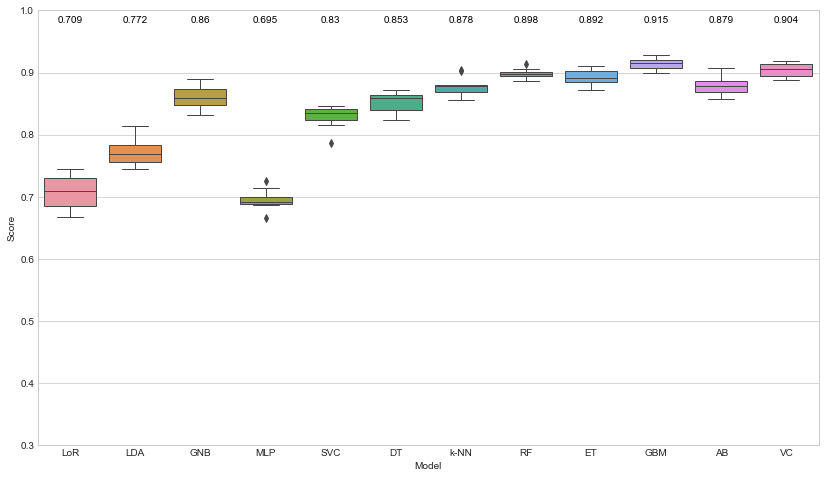

In [10]:
column_boxplot(topDf, 'values', 'accuracy_eas')

##  Error Boxplot

Populating the interactive namespace from numpy and matplotlib


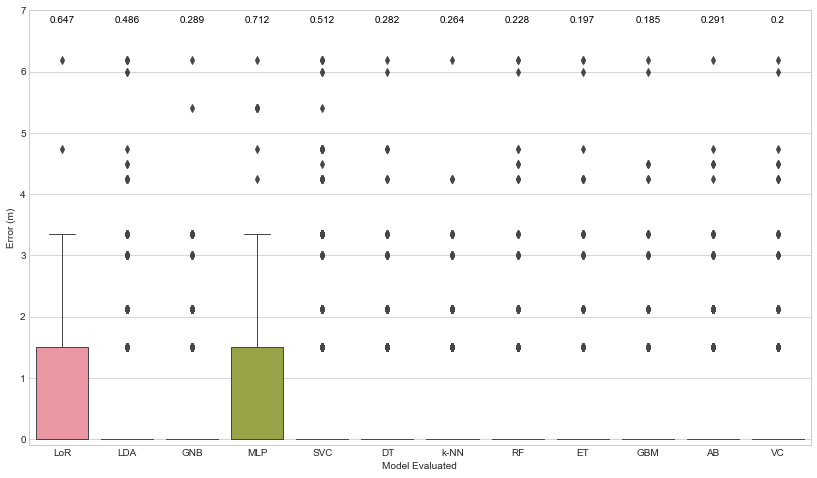

In [11]:
column_boxplot(topDf, 'error', 'error_eas_box')

##  Error Barplot

Populating the interactive namespace from numpy and matplotlib


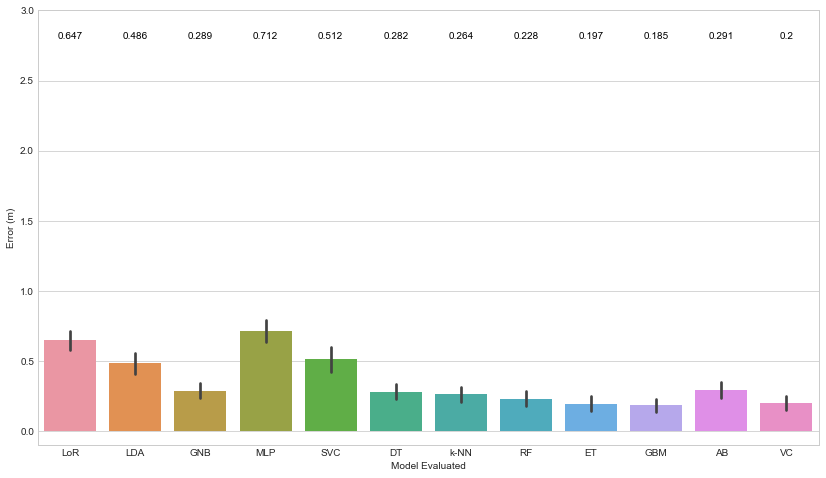

In [12]:
column_boxplot(topDf, 'error', 'error_eas_bar', box_bool=False)